In [ ]:
# basically I want to find if there's an inflection point in time (exposure time or mission time)
# at which the count rates for the detector no longer behave good 
# maybe this is the transition from poisson to gaussian? idk. more like the transiton in enough points for std dev 
# to reflect the aspect soln 

In [ ]:
import os
import re
import pandas as pd
from astropy.io import fits


# Initialize the dataframe
data = []

# Loop through all files in the main folder
for file_name in os.listdir(main_folder):
    if file_name.endswith('.fits'):
        # Extract the eclipse number from the filename
        match = re.search(r'e(\d+)_', file_name)
        if not match:
            continue
        eclipse = int(match.group(1))
        
        main_folder = '/media/bekah/BekahA/background_test/pics_and_photonlists/fuv_changetest_upperquart'
        hmask_template = f'/media/bekah/BekahA/background_test/pics_and_photonlists/e{eclipse}-fd-hmask.fits'
        cmask_template = f'/media/bekah/BekahA/background_test/pics_and_photonlists/e{eclipse}-fd-cmask.fits'
        # Open the primary FITS file to get the 'exptime'
        fits_path = os.path.join(main_folder, file_name)
        with fits.open(fits_path) as hdul:
            exptime = hdul[0].header.get('EXPTIME', None)

        # Initialize pixel sums for hmask and cmask
        hmask_sum, cmask_sum = None, None

        # Process the hmask FITS file
        hmask_path = hmask_template.format(eclipse=eclipse)
        if os.path.exists(hmask_path):
            with fits.open(hmask_path) as hdul:
                hmask_sum = hdul[0].data.sum()

        # Process the cmask FITS file
        cmask_path = cmask_template.format(eclipse=eclipse)
        if os.path.exists(cmask_path):
            with fits.open(cmask_path) as hdul:
                cmask_sum = hdul[0].data.sum()

        # Append the data to the list
        data.append({'eclipse': eclipse, 'exptime': exptime, 'hmask_sum': hmask_sum, 'cmask_sum': cmask_sum})

# Convert the list of data to a pandas DataFrame
df = pd.DataFrame(data)

# Return the dataframe
print(df)


In [ ]:
df

In [ ]:
from matplotlib import pyplot as plt 

plt.scatter(df['exptime'],df['hmask_sum'])

In [ ]:
plt.scatter(df['exptime'],df['cmask_sum'])

In [ ]:
plt.scatter(df['cmask_sum'],df['hmask_sum'])

In [1]:
from pyarrow import parquet
from quickbin import bin2d
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from astropy.io import fits


In [20]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    import numpy as np
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)

    if isinstance(image, np.ma.MaskedArray):
        return result

    return result.data

In [41]:
eclipse = 13338

photon_file = f"/media/bekah/BekahA/background_test/pics_and_photonlists/e{eclipse}/e{eclipse}-fd-b00.parquet"

nf = parquet.read_table(photon_file, columns=['col', 'row', 'ra', 'dec', 't']).to_pandas()
# for reading row groups
#photonlist = parquet.ParquetFile(photon_file)
#nf = photonlist.read_row_groups([0],columns=['col', 'row', 'ra', 'dec', 't']).to_pandas()
nf['row_rnd'] = nf['row'].round().astype(int)
nf['col_rnd'] = nf['col'].round().astype(int)
print("filtering photonlist")
# filtering photonlist for on detector because read_row_groups can't
nf = nf[(nf['col_rnd'] <= 800) & (nf['row_rnd'] <= 800)
        & (nf['ra'] != 0) & (nf['dec'] != 0)
        & (nf['col_rnd'] >= 0) & (nf['row_rnd'] >= 0)]
mask = pd.notna(nf['ra'])
nf = nf[mask]
print("calculating expt & adding edge points")
# rough approx not accounting for dead time
expt = nf.iloc[len(nf) - 1]['t'] - nf.iloc[0]['t']
# adding edge points, have 'real' values from photonlist to
# not mess with the stats too much
ra = nf.iloc[0]['ra']
dec = nf.iloc[0]['dec']
t = nf.iloc[0]['t']
edge_points = pd.DataFrame({
    'col': [0, 0, 800, 800],
    'row': [0, 800, 0, 800],
    'ra': [ra,ra,ra,ra],
    'dec': [dec,dec,dec,dec],
    't': [t,t,t,t]
})
nf = pd.concat([nf, edge_points], ignore_index=True)

nbins = 800 
print("quickbinning")
ra_dict = bin2d(x_arr=nf['col'], y_arr=nf['row'], val_arr=nf['ra'], n_bins=nbins, op=('std', 'count'))
dec_stdev = bin2d(x_arr=nf['col'], y_arr=nf['row'], val_arr=nf['dec'], op='std', n_bins=nbins)

cnt = bin2d(x_arr=nf['ra'],y_arr=nf['dec'],val_arr=nf['col'], n_bins=nbins, op=('std','count'))
count = ra_dict['count'] / expt

filtering photonlist
calculating expt & adding edge points
quickbinning


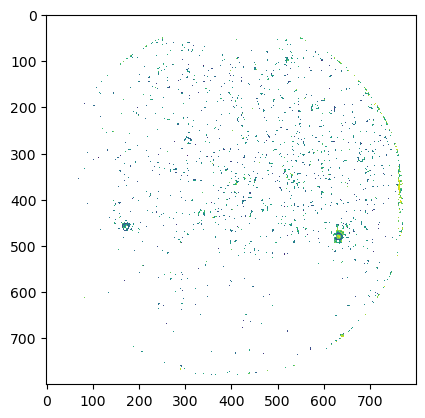

In [42]:
plt.imshow(centile_clip(ra_dict['std']+dec_stdev),interpolation=None)

In [43]:
ra_dict['std']

array([[ 0., nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0., nan, nan, ..., nan, nan,  0.]])

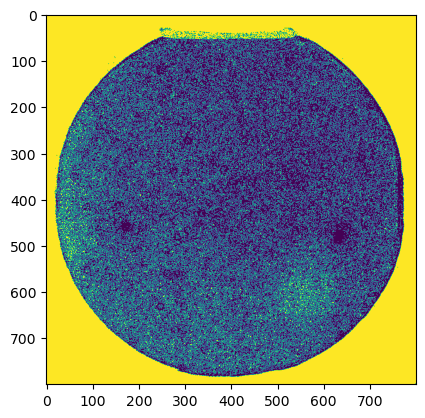

In [44]:
plt.imshow(count==0)

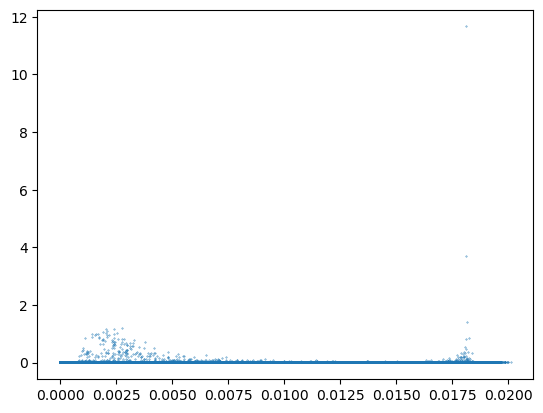

In [46]:
plt.scatter(np.ravel(ra_dict['std'])+np.ravel(dec_stdev),np.ravel(count),s=.1,alpha=1)